### In this notebook, we generate a 3D synthetic volume with a randomized mesh network of tubular objects. 


Code writer: Hyoungjun Park 

Contact: peterpark828@icloud.com OR peterpark828@kaist.ac.kr

In [1]:
from matplotlib import pyplot as plt 
import numpy as np
import os
import math
import sys

from tifffile import imsave
import scipy.ndimage as ndimage
import scipy.signal as signal
%matplotlib inline
from skimage.draw import line_nd
from skimage.draw import line_aa
from skimage.draw import line

import elasticdeform
import os

In [2]:
def normalize(img_np, invert=False):
    img_min = np.min(img_np)
    img_max = np.max(img_np)

    new_min = 0
    new_max = 1
    img_normd = (img_np - img_min) * ((new_max - new_min) / (img_max - img_min)) + new_min

    if invert:
        img_normd = new_max - img_normd

    return img_normd

----

Set parameters. 

In [4]:
std = 4 # std of Gaussian blurring 
ROI_size = 500 # dimension of the synthetic volume per axis. 
object_num = 2000 # number of objects for lines 

sigma_=2 #deformation parameter
points_=50 #deformation parameter

Save directory. 

In [5]:
parent_dir = '/scratch/park/data/simulation_data/haystack'
if not os.path.isdir(parent_dir):
    os.makedirs(parent_dir)

psf_file_name = f'{object_num}-lines-blurred-by-gaublur-std-' +str(std)
model = 'haystack'
save_dir = os.path.join(parent_dir, 'simulation_data/', model, psf_file_name)

In [6]:
save_dir

'/scratch/park/data/simulation_data/haystack/simulation_data/haystack/2000-lines-blurred-by-gaublur-std-4'

Save directory for before-deformation.

In [7]:
save_before_deform_dir = os.path.join(save_dir, 'before_deform')
print(save_before_deform_dir)
if not os.path.isdir(save_before_deform_dir):
    os.makedirs(save_before_deform_dir)

/scratch/park/data/simulation_data/haystack/simulation_data/haystack/2000-lines-blurred-by-gaublur-std-4/before_deform


Save directory for Ground-truth

In [8]:
GT_deform_dir = os.path.join(save_dir, 'GT')
print(GT_deform_dir)
if not os.path.isdir(GT_deform_dir):
    os.makedirs(GT_deform_dir)

/scratch/park/data/simulation_data/haystack/simulation_data/haystack/2000-lines-blurred-by-gaublur-std-4/GT


Save dirtecotry for Blurring 

In [9]:
blurred_deform_dir = os.path.join(save_dir, 'blurred')

if not os.path.isdir(blurred_deform_dir):
    os.makedirs(blurred_deform_dir)

Save dirtecotry for Blurring after 90-degree rotation. 

In [10]:
blurred_xz_deform_dir = os.path.join(save_dir, 'rotated_xz_blurred')

print(blurred_xz_deform_dir)
if not os.path.isdir(blurred_xz_deform_dir):
    os.makedirs(blurred_xz_deform_dir)

/scratch/park/data/simulation_data/haystack/simulation_data/haystack/2000-lines-blurred-by-gaublur-std-4/rotated_xz_blurred


Test drawing one random line. 

In [11]:
start_x = np.random.randint(0,ROI_size)
end_x = np.random.randint(0, ROI_size)
start_y = np.random.randint(0,ROI_size)
end_y = np.random.randint(0, ROI_size)

In [12]:
line_pts = line_aa(start_x, end_x, start_y, end_y)

In [44]:
line_pts

(array([402, 401, 400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 390,
        389, 388, 387, 386, 385, 384, 383, 382, 381, 380, 379, 378, 377,
        376, 375, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 364,
        363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351,
        350, 349, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 338,
        337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325,
        324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312,
        311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 299,
        298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286,
        285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273,
        272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260,
        259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247,
        246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234,
        233, 232, 231, 230, 229, 228, 227, 226, 225

In [13]:
canvas = np.zeros((ROI_size,ROI_size))

In [14]:
for i in range(len(line_pts[0])):
    canvas[line_pts[0][i], line_pts[1][i]] = 100

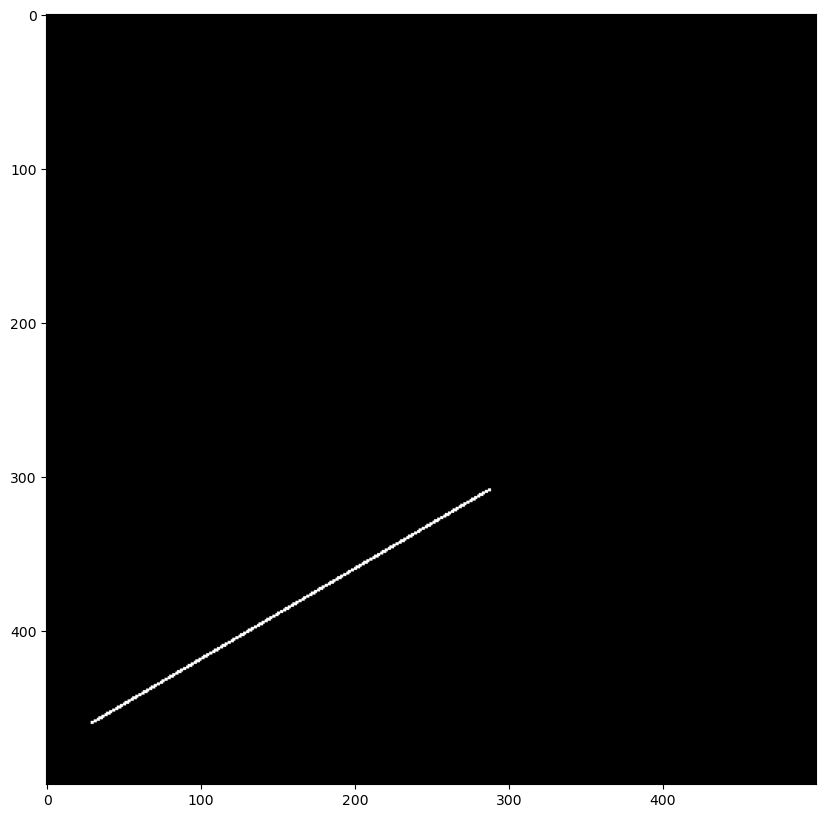

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(canvas, cmap = 'gray')

In [16]:
canvas = np.zeros((ROI_size,ROI_size))

In [17]:
for t in range(20):
    start_x = np.random.randint(0,ROI_size)
    end_x = np.random.randint(0, ROI_size)
    start_y = np.random.randint(0,ROI_size)
    end_y = np.random.randint(0, ROI_size)
    
    line_pts = line_aa(start_x, end_x, start_y, end_y)
    
    for i in range(len(line_pts[0])):
        canvas[line_pts[0][i], line_pts[1][i]] = 100


Test deformation. 

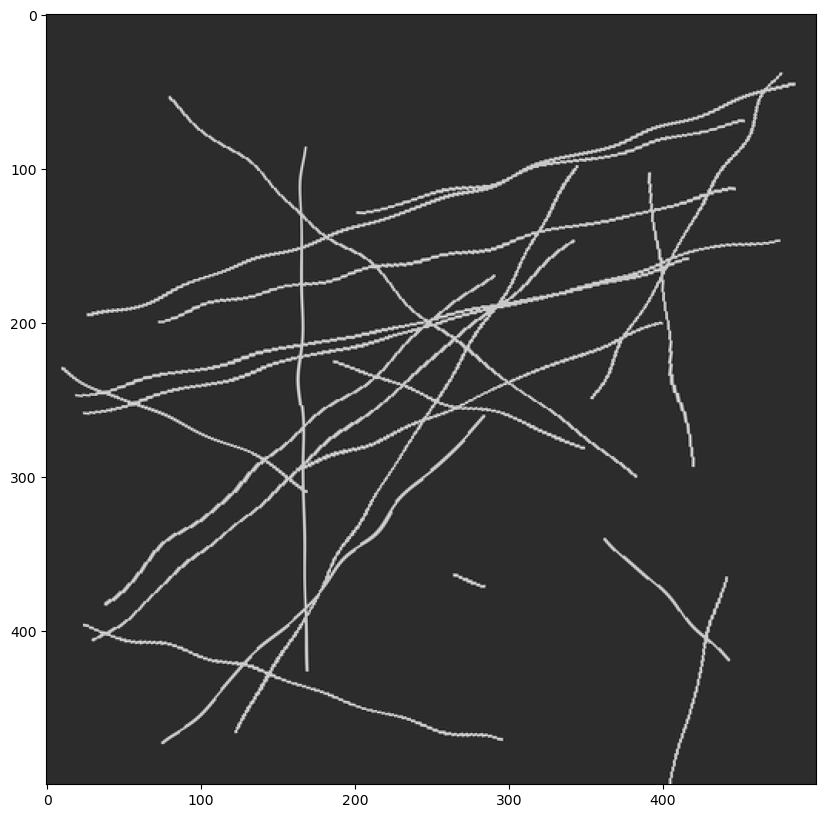

In [18]:
plt.figure(figsize=(10,10))
# X = np.zeros((200, 300))
# X[::10, ::10] = 1
# apply deformation with a random 3 x 3 grid
canvas_vol = elasticdeform.deform_random_grid(canvas, sigma=2, points=20)
plt.imshow(canvas_vol, cmap = 'gray')

## Now, 3D volume with random lines

In [19]:
start_x = np.random.randint(0,ROI_size)
end_x = np.random.randint(0, ROI_size)

start_y = np.random.randint(0,ROI_size)
end_y = np.random.randint(0, ROI_size)

start_z =  np.random.randint(0, ROI_size)
end_z =  np.random.randint(0, ROI_size)

In [20]:
canvas_vol = np.zeros((ROI_size, ROI_size, ROI_size))

In [21]:
for t in range(object_num):
    indice = [np.random.randint(0, ROI_size) for i in range(6)]
    
    start_pt, end_pt = indice[:3], indice[3:]
    
    line_pts = line_nd(start_pt, end_pt) 

    for i in range(len(line_pts[0])):
        canvas_vol[line_pts[0][i], line_pts[1][i], line_pts[2][i]] = (2**16-1)*(2/3)    

### Slice

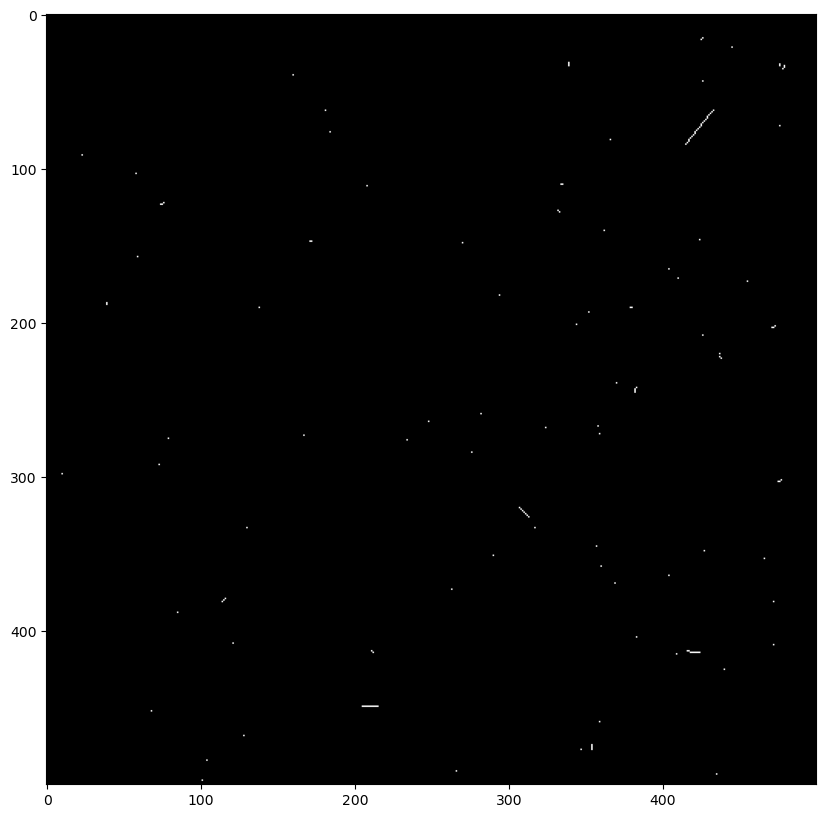

In [22]:
plt.figure(figsize=(10,10))
# X = np.zeros((200, 300))
# X[::10, ::10] = 1
# apply deformation with a random 3 x 3 grid
plt.imshow(canvas_vol[10], cmap = 'gray')

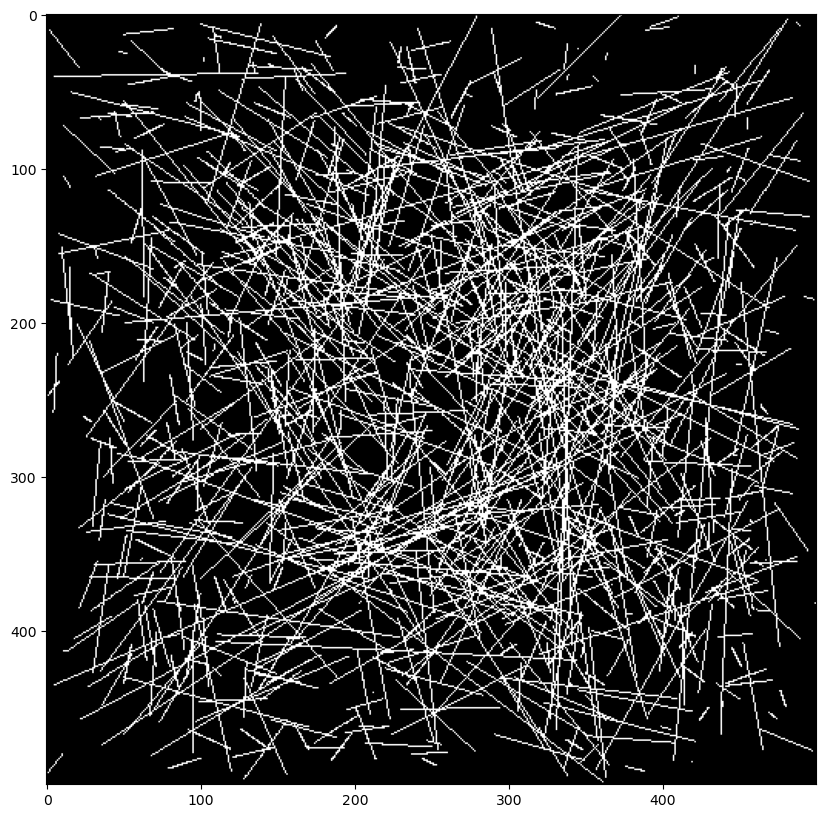

In [23]:
plt.figure(figsize=(10,10))
# X = np.zeros((200, 300))
# X[::10, ::10] = 1
# apply deformation with a random 3 x 3 grid
plt.imshow(np.amax(canvas_vol[100:150],0), cmap = 'gray')

## Try convolving with 3D Gaussian or average filter to make the lines thicker. 

In [24]:
from scipy import ndimage, misc

In [25]:
canvas_vol = ndimage.uniform_filter(canvas_vol, size=2)

In [26]:
canvas_vol[canvas_vol>100] = (2**16-1)*(2/3)

In [27]:
canvas_vol[canvas_vol<100] = 0

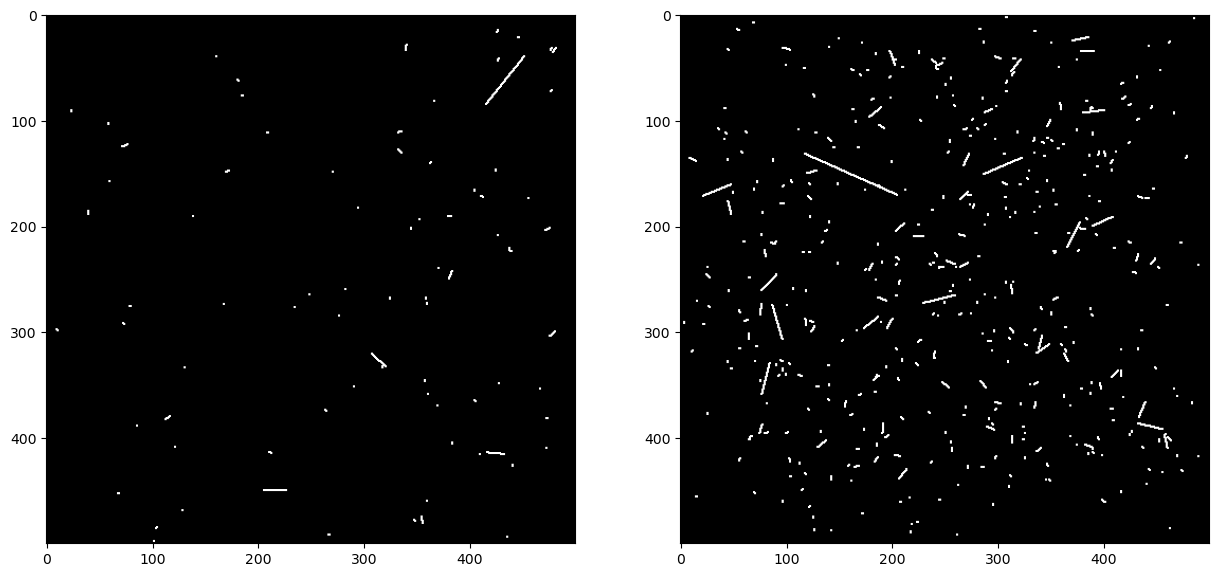

<Figure size 1000x1000 with 0 Axes>

In [28]:
figs, axs = plt.subplots(1,2,figsize=(15,15))
figs = plt.figure(figsize=(10,10))
axs[0].imshow(canvas_vol[10], cmap = 'gray')
axs[1].imshow(canvas_vol[60], cmap = 'gray')

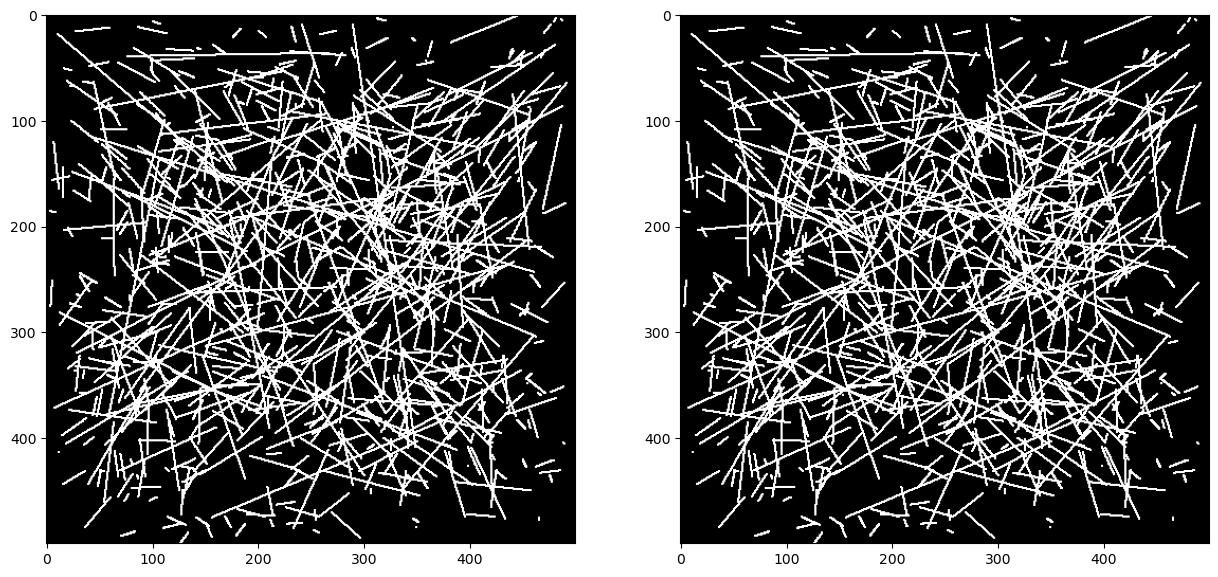

<Figure size 1000x1000 with 0 Axes>

In [29]:
figs, axs = plt.subplots(1,2,figsize=(15,15))
figs = plt.figure(figsize=(10,10))
axs[0].imshow(np.amax(canvas_vol[80:110],0), cmap = 'gray')
axs[1].imshow(np.amax(canvas_vol[80:110],0), cmap = 'gray')

In [30]:
canvas_vol_save = canvas_vol.astype(np.uint16)

In [31]:
imsave(save_before_deform_dir + '/before_deform.tiff', canvas_vol_save)

------

### Deform

In [32]:
canvas_vol = elasticdeform.deform_random_grid(canvas_vol, sigma=sigma_, points=points_)

In [33]:
np.min(canvas_vol), np.max(canvas_vol)

(-18450.510639562643, 73044.76957549244)

In [34]:
canvas_vol = np.clip(canvas_vol, 0, None)

In [35]:
np.min(canvas_vol), np.max(canvas_vol)

(0.0, 73044.76957549244)

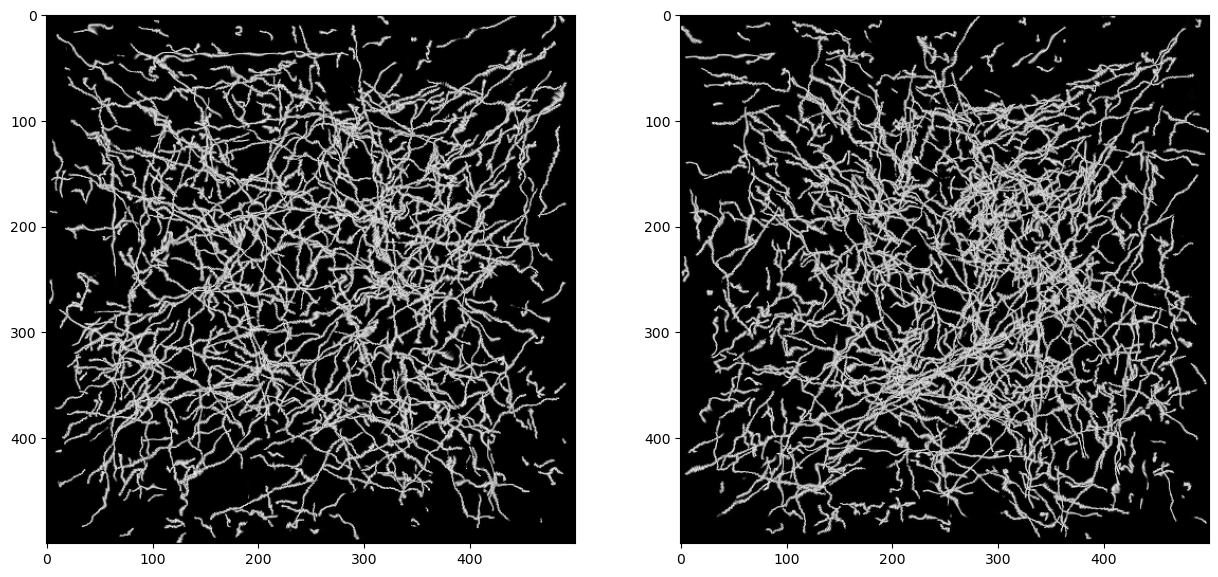

<Figure size 1000x1000 with 0 Axes>

In [36]:
figs, axs = plt.subplots(1,2,figsize=(15,15))
figs = plt.figure(figsize=(10,10))
axs[0].imshow(np.amax(canvas_vol[80:110],0), cmap = 'gray')
axs[1].imshow(np.amax(canvas_vol[110:140],0), cmap = 'gray')

### Save this as GT. 

In [37]:
canvas_vol_save = (canvas_vol-np.mean(canvas_vol))/np.std(canvas_vol)
canvas_vol_save = normalize(canvas_vol_save) * (2**16-1)
canvas_vol_save = canvas_vol_save.astype(np.uint16)

In [38]:
imsave(GT_deform_dir + '/GT.tiff', canvas_vol_save)

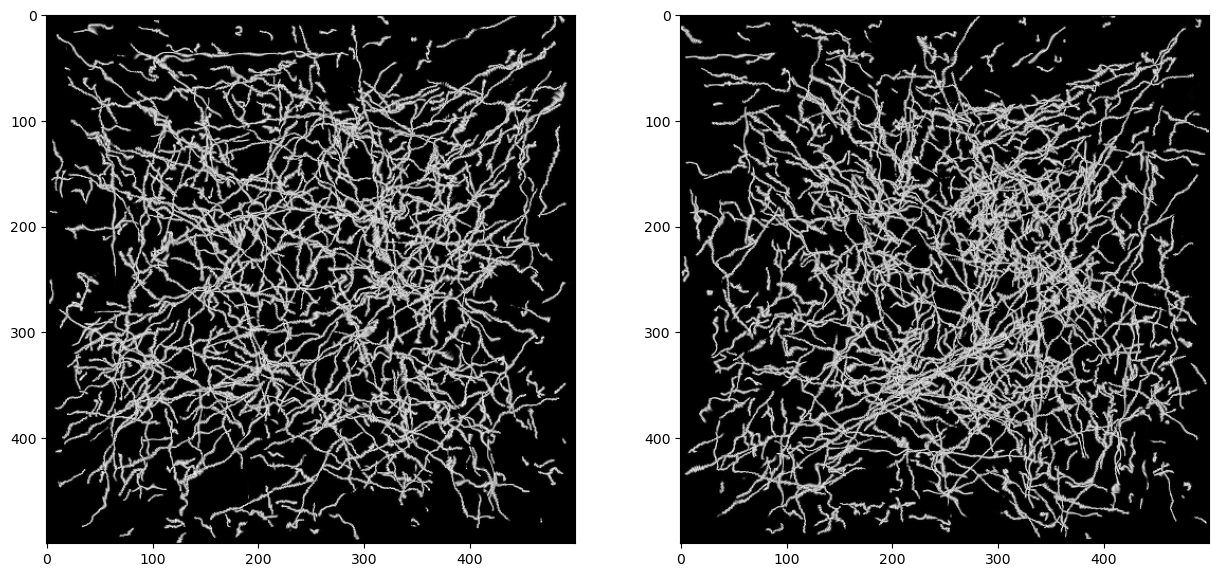

<Figure size 1000x1000 with 0 Axes>

In [39]:
figs, axs = plt.subplots(1,2,figsize=(15,15))
figs = plt.figure(figsize=(10,10))
axs[0].imshow(np.amax(canvas_vol_save[80:110],0), cmap = 'gray')
axs[1].imshow(np.amax(canvas_vol_save[110:140],0), cmap = 'gray')

----

# Convolve with Z-Gaussian 

In [40]:
canvas_vol = (canvas_vol-np.mean(canvas_vol))/np.std(canvas_vol)

In [41]:
canvas_vol = normalize(canvas_vol)

In [42]:
fitler_size = 31

In [43]:
gau_filter_ = signal.gaussian(fitler_size,std)
# gau_filter_ = np.reshape(gau_filter_, (1,31))

AttributeError: module 'scipy.signal' has no attribute 'gaussian'

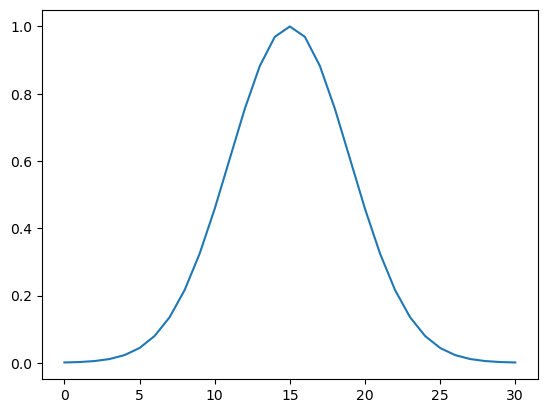

In [43]:
plt.figure()
plt.plot(gau_filter_.squeeze())

In [44]:
gau_filter = np.zeros((fitler_size,fitler_size,fitler_size))

In [45]:
middle = int(gau_filter_.shape[0]/2)
print(middle)
gau_filter[:,middle,middle] = gau_filter_

15


In [46]:
canvas_vol_blurred = signal.fftconvolve(canvas_vol, gau_filter, mode='same')

In [47]:
canvas_vol_blurred_save = (canvas_vol_blurred-np.mean(canvas_vol_blurred))/np.std(canvas_vol_blurred)
canvas_vol_blurred_save = normalize(canvas_vol_blurred_save) * (2**16-1)
canvas_vol_blurred_save = canvas_vol_blurred_save.astype(np.uint16)

Slice XY image comparison 

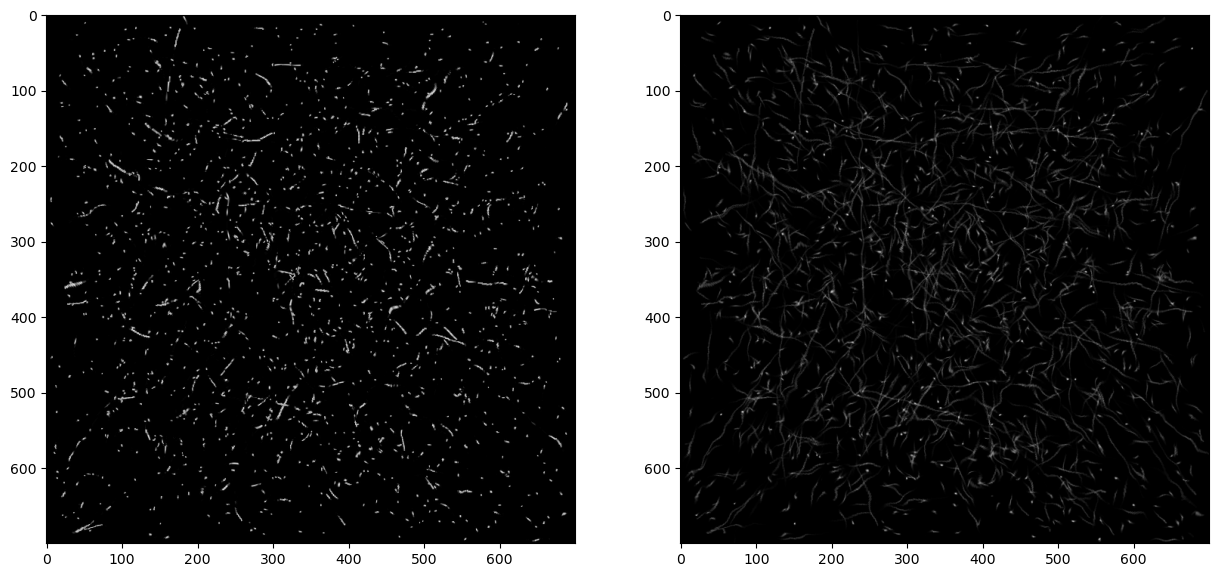

<Figure size 1000x1000 with 0 Axes>

In [48]:
figs, axs = plt.subplots(1,2,figsize=(15,15))
figs = plt.figure(figsize=(10,10))
axs[0].imshow(canvas_vol[110], cmap = 'gray')
axs[1].imshow(canvas_vol_blurred[110], cmap = 'gray')

Slice XZ image comparison 

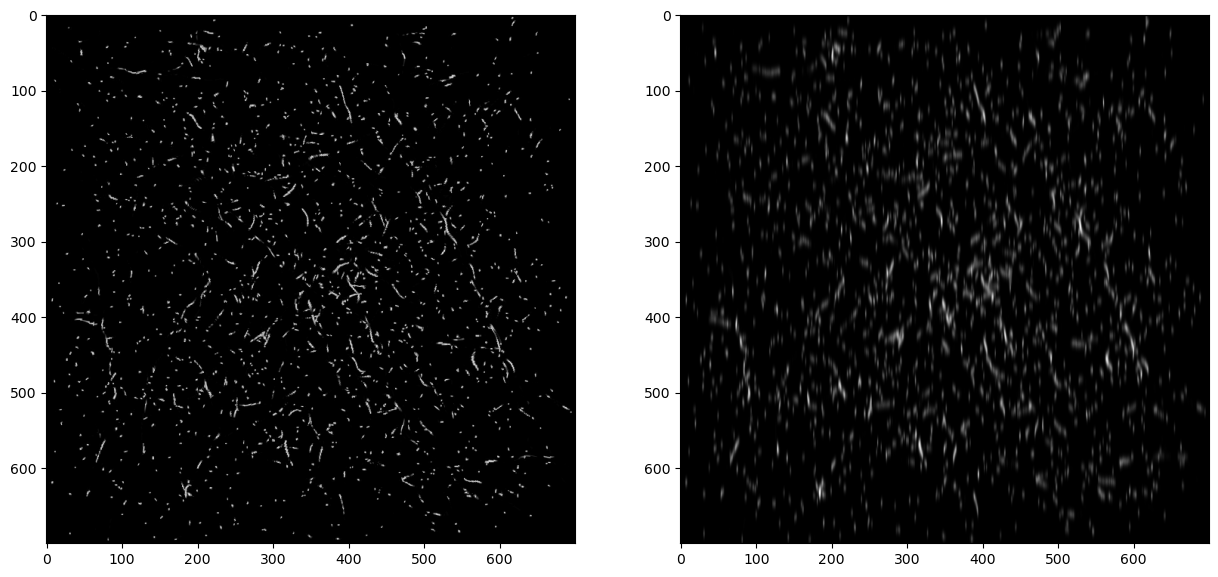

<Figure size 1000x1000 with 0 Axes>

In [49]:
figs, axs = plt.subplots(1,2,figsize=(15,15))
figs = plt.figure(figsize=(10,10))
axs[0].imshow(canvas_vol[:,110,:], cmap = 'gray')
axs[1].imshow(canvas_vol_blurred[:,110,:], cmap = 'gray')

MIP XY image comparison 

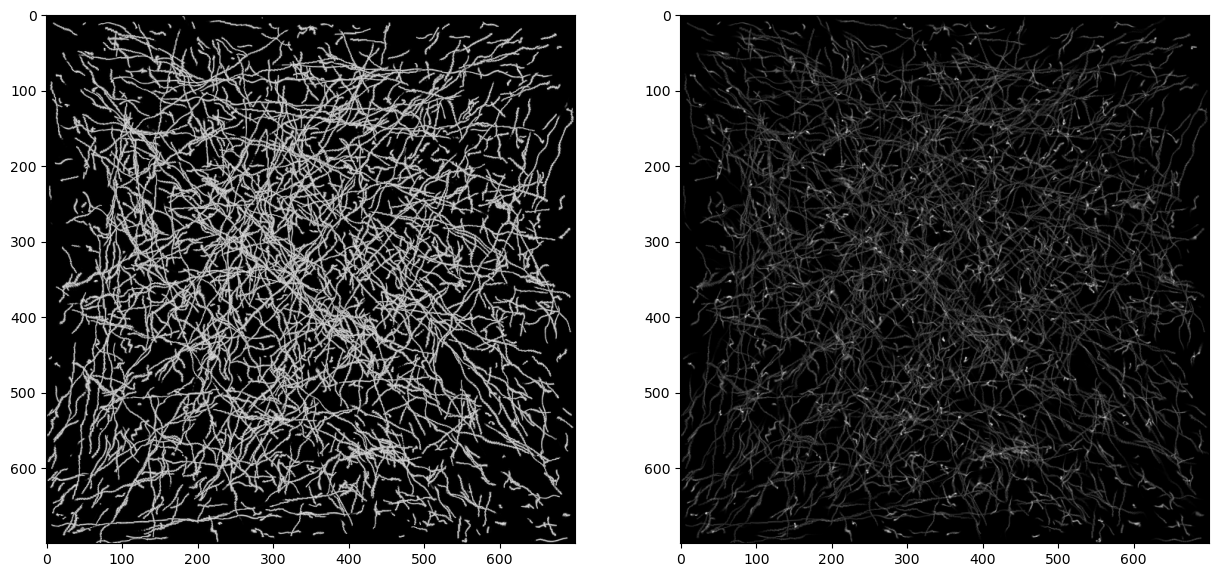

<Figure size 1000x1000 with 0 Axes>

In [50]:
figs, axs = plt.subplots(1,2,figsize=(15,15))
figs = plt.figure(figsize=(10,10))
axs[0].imshow(np.amax(canvas_vol[80:110],0), cmap = 'gray')
axs[1].imshow(np.amax(canvas_vol_blurred[80:110],0), cmap = 'gray')

MIP XZ image comparison

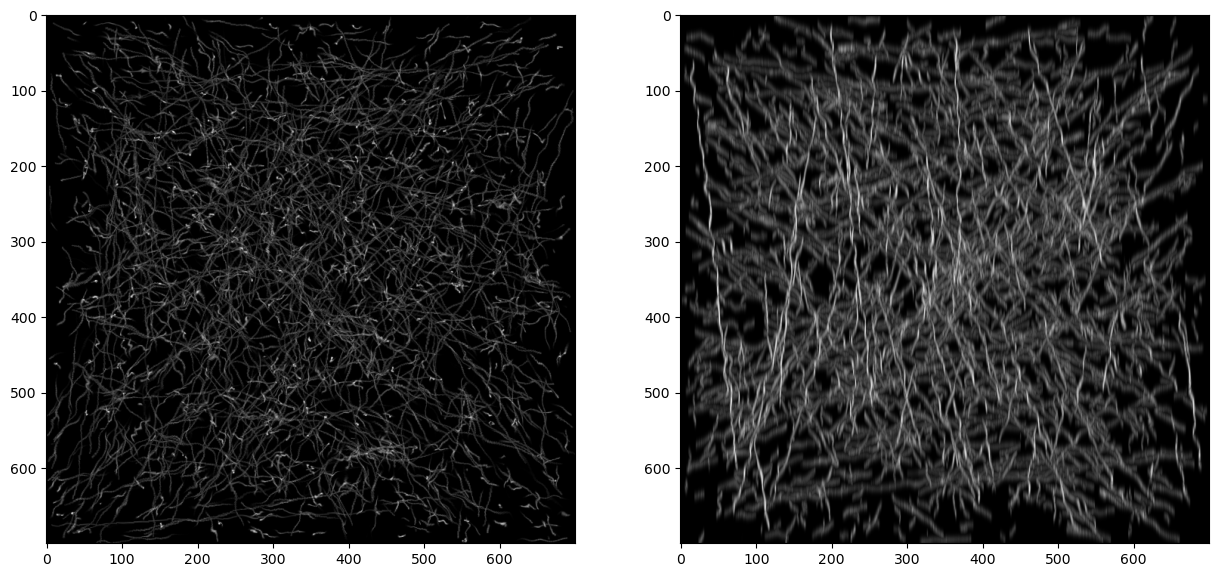

<Figure size 1000x1000 with 0 Axes>

In [56]:
figs, axs = plt.subplots(1,2,figsize=(15,15))
figs = plt.figure(figsize=(10,10))
axs[0].imshow(np.amax(canvas_vol_blurred_save[80:110,:,:],0), cmap = 'gray')
axs[1].imshow(np.amax(canvas_vol_blurred_save[:,80:110,:],1), cmap = 'gray')

In [52]:
imsave(blurred_deform_dir + '/blurred.tiff', canvas_vol_blurred_save)

### Create the blurred volume after rotation (for comparison). 

In [53]:
canvas_vol_rotated_xz = np.swapaxes(canvas_vol, 0,1) # (z,y,x) -> (y,z,x)
canvas_vol_rotated_xz = signal.fftconvolve(canvas_vol_rotated_xz, gau_filter, mode='same')

In [54]:
canvas_vol_rotated_xz_save = (canvas_vol_rotated_xz-np.mean(canvas_vol_rotated_xz))/np.std(canvas_vol_rotated_xz)
canvas_vol_rotated_xz_save = normalize(canvas_vol_rotated_xz_save) * (2**16-1)
canvas_vol_rotated_xz_save = canvas_vol_rotated_xz_save.astype(np.uint16)

In [55]:
imsave(blurred_xz_deform_dir+'/rotated_xz_blurred.tiff', canvas_vol_rotated_xz_save)